# **CI&T Stock Analysis**

Recentemente, a empresa CI&T foi listada na Bolsa de Valores de Nova Iorque, listada como CINT.

Por meio deste notebook, extrairemos a série histórica do preços das ações, desde a listagem até o dia atual. Tendo em mãos estes dados, um modelo que busca prever movimentações futuras será desenvolvido utilizando Redes Neurais Convolucionais.

O primeiro passo é instalar os pacotes necessários, a começar pelo yfinance.

In [1]:
!pip install yfinance==0.1.67

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

Primeiramente vamos acessar a ação desejada através do módulo Ticker e nos familiarizar com as informações disponíveis pelo função history do yfinance:

In [3]:
cit = yf.Ticker("CINT")
cit_info = cit.history()
cit_info.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03,11.96,12.400,11.85,11.95,49000,0,0
2022-01-04,12.03,12.325,11.11,11.76,122100,0,0
2022-01-05,11.75,12.000,9.97,10.19,277100,0,0
2022-01-06,10.37,10.950,10.14,10.85,76100,0,0
2022-01-07,10.90,12.060,10.81,11.14,106400,0,0


Agora extrairemos a série histórica de preços e alocaremos os dados que nos interessam em numpy arrays.

Note que estamos utilizando o preço médio de cada dia através da média aritmética entre a máxima e a mínima, pois esta métrica pode ser mais importante para algumas análises.

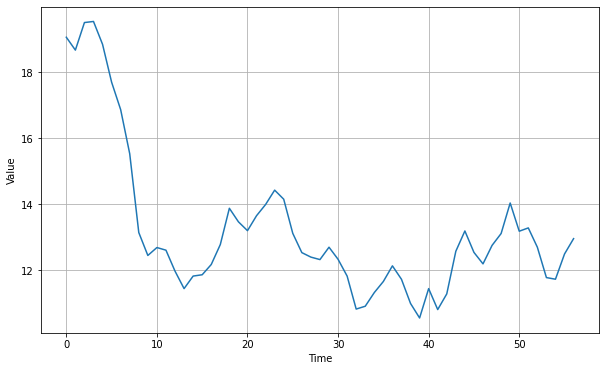

In [4]:
cit_share_price_data = cit.history(period="max")
cit_share_price_data.head()
cit_share_price_data.reset_index(inplace=True)

series_avg = []
for i,j in zip(cit_share_price_data["High"], cit_share_price_data["Low"]):
  series_avg.append((i+j)/2)

time = []
step = 0
time_open = cit_share_price_data["Date"]
for i in time_open:
  time.append(step)
  step = step + 1
time = np.array(time)

series = []
for i in series_avg:
  i = float(i)
  series.append(i)
series = np.array(series)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time, series)

Separando os dados para treinamento e para validação. Os 16 últimos dias serão reservados para a previsão, também chamada de Forecasting.

In [5]:
split_time = len(time) - 16
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 2
shuffle_buffer_size = 20

Definimos duas funções importantes para o treinamento e forecasting

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(2).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Neste ponto, um modelo será treinado por 100 épocas com o intuito de encontrar o melhor Learning Rate para o Optimizer.

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 20
batch_size = 2
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(41,)
Epoch 1/100
11/11 [==============================] - 8s 121ms/step - loss: 25.3268 - mae: 25.8176 - lr: 1.0000e-08
Epoch 2/100
11/11 [==============================] - 0s 39ms/step - loss: 24.8475 - mae: 25.3371 - lr: 1.1220e-08
Epoch 3/100
11/11 [==============================] - 0s 41ms/step - loss: 24.0605 - mae: 24.5525 - lr: 1.2589e-08
Epoch 4/100
11/11 [==============================] - 0s 36ms/step - loss: 22.9700 - mae: 23.4618 - lr: 1.4125e-08
Epoch 5/100
11/11 [==============================] - 0s 38ms/step - loss: 21.5642 - mae: 22.0561 - lr: 1.5849e-08
Epoch 6/100
11/11 [==============================] - 0s 43ms/step - loss: 19.9062 - mae: 20.3995 - lr: 1.7783e-08
Epoch 7/100
11/11 [==============================] - 0s 37ms/step - loss: 18.0981 - mae: 18.5948 - lr: 1.9953e-08
Epoch 8/100
11/11 [==============================] - 0s 40ms/step - loss: 16.1846 - mae: 16.6828 - lr

O gráfico a seguir mostra qual Learning Rate é este.

(1e-08, 0.0001, 0.0, 60.0)

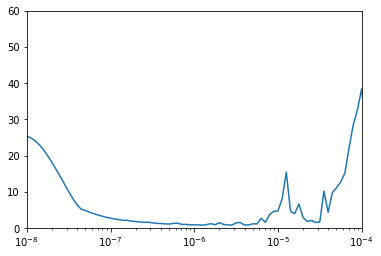

In [9]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

Agora colocaremos o o melhor valor de Lr e efetuaremos o treinamento definitivo

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
11/11 [==============================] - 4s 21ms/step - loss: 31.1067 - mae: 31.6050
Epoch 2/500
11/11 [==============================] - 0s 17ms/step - loss: 11.7285 - mae: 12.2224
Epoch 3/500
11/11 [==============================] - 0s 17ms/step - loss: 7.5070 - mae: 7.9971
Epoch 4/500
11/11 [==============================] - 0s 17ms/step - loss: 4.0222 - mae: 4.4994
Epoch 5/500
11/11 [==============================] - 0s 18ms/step - loss: 2.5437 - mae: 2.9922
Epoch 6/500
11/11 [==============================] - 0s 19ms/step - loss: 1.9149 - mae: 2.3482
Epoch 7/500
11/11 [==============================] - 0s 19ms/step - loss: 1.5073 - mae: 1.9324
Epoch 8/500
11/11 [==============================] - 0s 19ms/step - loss: 1.2676 - mae: 1.6751
Epoch 9/500
11/11 [==============================] - 0s 18ms/step - loss: 1.1010 - mae: 1.4911
Epoch 10/500
11/11 [==============================] - 0s 18ms/step - loss: 0.9594 - mae: 1.3441
Epoch 11/500
11/11 [=========================

Executando a previsão

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

**Enfim, o resultado!** O gráfico em laranja representa a previsão que a Rede Neural teria feito do preço médio das ações da CI&T nos últimos 16 dia, sem que tivesse contato com os dados reais, e o gráfico em azul mostra o preço médio que de fato ocorreu no mercado ao longo deste mesmo período de tempo.

Este notebook pode ser adaptado para fazer previsões sobre dias futuros e outra versão dele será incluída no repositório em breve para atender esta função

[41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56]


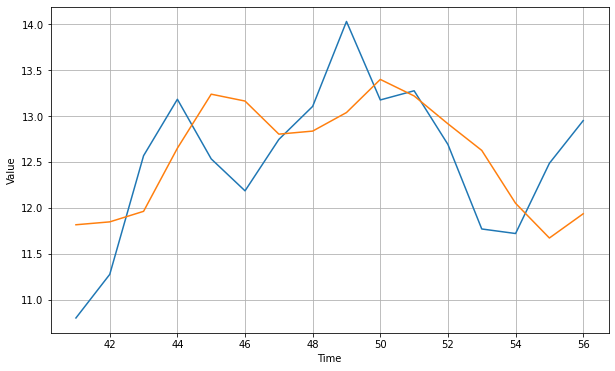

In [12]:
plt.figure(figsize=(10, 6))
print(time_valid)
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

Aqui temos a métrica de erro

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.5779199

E aqui a diminuição do Loss e MAE ao longo das 500 iterações

<Figure size 432x288 with 0 Axes>

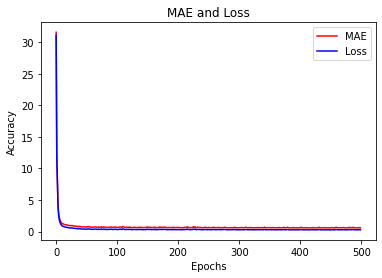

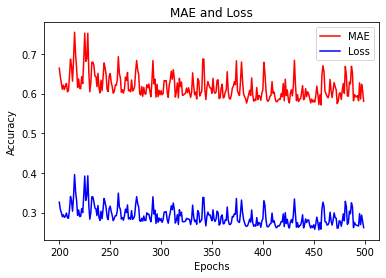

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()